In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from copy import deepcopy

from postprocessing import drop_similar, update_occupations, filter_rare_occupations, filter_outlier_wikidata
from postprocessing import update_occupations, upd_single_occ
from postprocessing import filter_irrelevant
from postprocessing import prefered_occs

from fuzzywuzzy import fuzz

from os.path import join
import json
from figures import plot_hists

DATA_PATH = 'data'

df = pd.read_json(join(DATA_PATH, 'union.json'), lines=True)
df["s"] = df["s"].apply(lambda x: x.lower())
del df["id"]

> Loading some usefule files

In [2]:
with open(join(DATA_PATH, 'countries_vocab.json'), 'r', encoding="utf-8") as f:
    countries_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    coun_num = len(set(countries_dict.values()))
    print(f"Number of countries: {coun_num}")
    
with open(join(DATA_PATH, 'occupations_vocab.json'), 'r', encoding="utf-8") as f:
    occupations_dict = {k: str(v.lower().strip()) for k, v in json.loads(f.readline()).items()}
    occ_num = len(set(occupations_dict.values()))
    print(f"Number of occupations: {occ_num}")
with open(join("postprocessing", 'name2occ.json'), 'r', encoding="utf-8") as f:
    name2occ =  json.loads(f.read())

Number of countries: 180
Number of occupations: 1249


>Columns:  
q = "quote"  
d = "date"  
s = "speaker"  
o = "occurancies"  
gender = gender of the speakers  
birth = birth dates of the speakers  
occupation_ids = wikidata ids of the speakers' occupancies  
citizenship_id = wikidata ids of the speakers' citizenship



In [3]:
df.head()

,q,d,s,o,gender,birth,occupation_ids,citizenship_id
0,will be playing a lot of the tracks from micro...,2008-12-02 17:59:33,lockett pundt,1,[male],[+1982-10-07T00:00:00Z],[[Q855091]],[Q30]
1,the corporation looks a bit concerned there te...,2008-10-16 01:39:41,tessa martin,2,[female],[None],[[Q2500638]],[None]
2,the broker who supposed a large shareholder ha...,2008-12-01 10:39:05,anthony anderson,1,"[male, male, male, male, male]","[+1901-00-00T00:00:00Z, +1981-11-12T00:00:00Z,...","[[Q3282637], [Q3665646], [Q245068, Q10800557, ...","[None, Q30, Q30, Q30, Q145]"
3,whining and bitching and am a sore loser,2008-11-05 07:41:00,barack obama,2,[male],[+1961-08-04T00:00:00Z],"[[Q82955, Q40348, Q15958642, Q28532974, Q37243...",[Q30]
4,everybody is a bit concerned with the economy ...,2008-10-17 01:25:29,jake hansen,3,[male],[+1989-08-21T00:00:00Z],[[Q11774891]],[Q30]


> First of all we will drop the persons, which was not found in Wikidata. This persons should have a special attention, especially those, who have a big number of quotations. However for them we will need to manually join the information about a certain person, since their QID was not found in the current version Wikidata.

In [4]:
df = df[
    ~df.apply(
        lambda x: not(
            x["gender"] or \
            x["birth"] or \
            x["occupation_ids"] or \
            x["citizenship_id"]
        ), axis=1)
]

> Next we will get rid of quotes, which are not related to `bitcoin` and `crypto`. For instance quates, containing subphrases like: `little bit`, `bitching`

In [5]:
df = df[df["q"].apply(lambda x: filter_irrelevant(x))]

> Lets then preprocess the list of occupations we have. As can be observerd, there are multiple occupations containing similar words: e.g. `music teacher`, `biology teacher`, `school teacher`

> We will join all the profession containing `artist`, `player`, `video game`. Moreover we will replace `chief executive officer` with `executive director` to distingfish them from `police officer`

In [6]:
occupations_dict = update_occupations(occupations_dict)

In [7]:
occupations = [word.split() for word in occupations_dict.values()]
Counter(sum(occupations, [])).most_common()[:5]

[('sport', 199),
 ('media', 111),
 ('business', 81),
 ('science', 50),
 ('writer', 40)]

> Then we filter occupations, which occured only single time in the entire dataset, for instance, `ufc lightweight fighter`.

In [8]:
occ_freq = defaultdict(int)
for occ_ids in df["occupation_ids"].values:
    if occ_ids is not None:
        for occs in occ_ids:
            if occs is not None:
                for o in occs:
                    occ_freq[o] += 1
                
df = df.apply(lambda x: filter_rare_occupations(x, occ_freq), axis=1)

In [9]:
occ_set = set()
for occ_lsts in df["occupation_ids"].values:
    if occ_lsts is not None:
        for lst in occ_lsts:
            if lst is not None:
                occ_set.update(lst)
print(f"Reduced number of occupations: {len(occ_set)}")

Reduced number of occupations: 869


> Next we will fiter Wikidata pages without `occupation` or `citizenship`. Also we will filter `genders` and `citizenship`, which does not match the `gender` and `citizenship` of majority

In [10]:
df = df.apply(lambda x: filter_outlier_wikidata(x), axis=1)
df = df[~df.apply(lambda x: not(x["gender"] or x["birth"] or x["occupation_ids"] or x["citizenship_id"]), axis=1)]
percent = (df["citizenship_id"].apply(len) > 1).sum() / len(df)

print(f"Percent of quotations in dataset, where more then one QID is joined {percent}")  

df["gender"] = df["gender"].apply(lambda x: x[0])
df["citizenship_id"] = df["citizenship_id"].apply(lambda x: x[0])

Percent of quotations in dataset, where more then one QID is joined 0.1838344011828487


> Next we will split the dates

In [11]:
df['publish_year'] = df['d'].apply(lambda x: x[:4])
df['publish_month'] = df['d'].apply(lambda x: x[5:7])

> The first plot we build to validate if everything is correct is `number of occurancies` w.r.t. `publish year` 

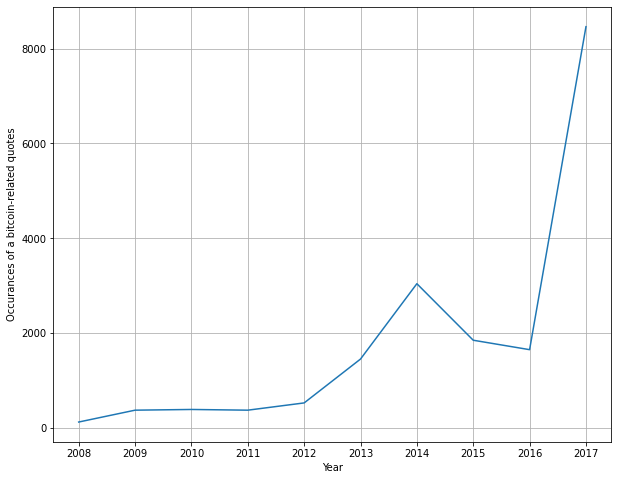

In [12]:
plt.figure(figsize=(10,8))
plt.plot(df.groupby('publish_year')['o'].count())
plt.xlabel("Year")
plt.ylabel("Occurances of a bitcoin-related quotes")
plt.grid()
plt.show()

> Seems like everything is okey, since the two main increases in popularity of bitcoin was indeed in `2014` and `2017`, according to the `Google trends`

> The most cited pearsons also seems reasonable

In [13]:
df.groupby(['s']).sum()['o'].sort_values(ascending=False).head()

s
jamie dimon        665
mark karpeles      626
thomas peterffy    589
craig wright       586
adrian lee         585
Name: o, dtype: int64

> Then we will reduce the number of occupations, since most of them are very simmilar. We will utilize `fuzzywuzzy` to find similar words. Then we will build a graph, where the vertices are the `occupations`, and adge between $o_i$ and $o_j$ exists if the similarity in terms of `fuzzywuzzy` metric is greater then a treshold.

In [14]:
occupations_dict = drop_similar(occupations_dict)

In [15]:
names1 = (df.groupby("s").sum() > 10).reset_index()
names1 = names1.loc[names1["o"], "s"]
names1 = set(names1.values)
names2 = (df.groupby("s").count() > 3).reset_index()
names2 = names2.loc[names2["o"], "s"]
names2 = set(names2.values)
names = names2.intersection(names1)

df = df[df["s"].apply(lambda x: x in names)]

In [16]:
def select_occupation(x):
    output = []
    for elem in x:
        if elem is not None:
            output += list(occupations_dict[e] for e in elem)
    output = [o for o in output if o != "cryptozoologist"]
    result = [item for item, c in Counter(output).most_common()]
    if not output:
        return None
    else:
        for o in output:
            if "crypto" in o:
                return o
            
        if len(output) > 1:
            for n in prefered_occs:
                if n in output:
                    return n
            
        first = output[0].strip()
        if first in ["sport", "writer", "media"]:
            if len(output) > 1:
                return output[1]
        else:
            return output[0]

In [17]:
df = df[df["birth"].apply(lambda x: len(x) < 2)]
df["occupation"] = df["occupation_ids"].apply(lambda x: select_occupation(x))
df["occupation"] = df.apply(lambda x: name2occ[x["s"]] if x["s"] in name2occ else x["occupation"], axis=1)
df["occupation"] = df.apply(lambda x: upd_single_occ(x["occupation"]), axis=1)

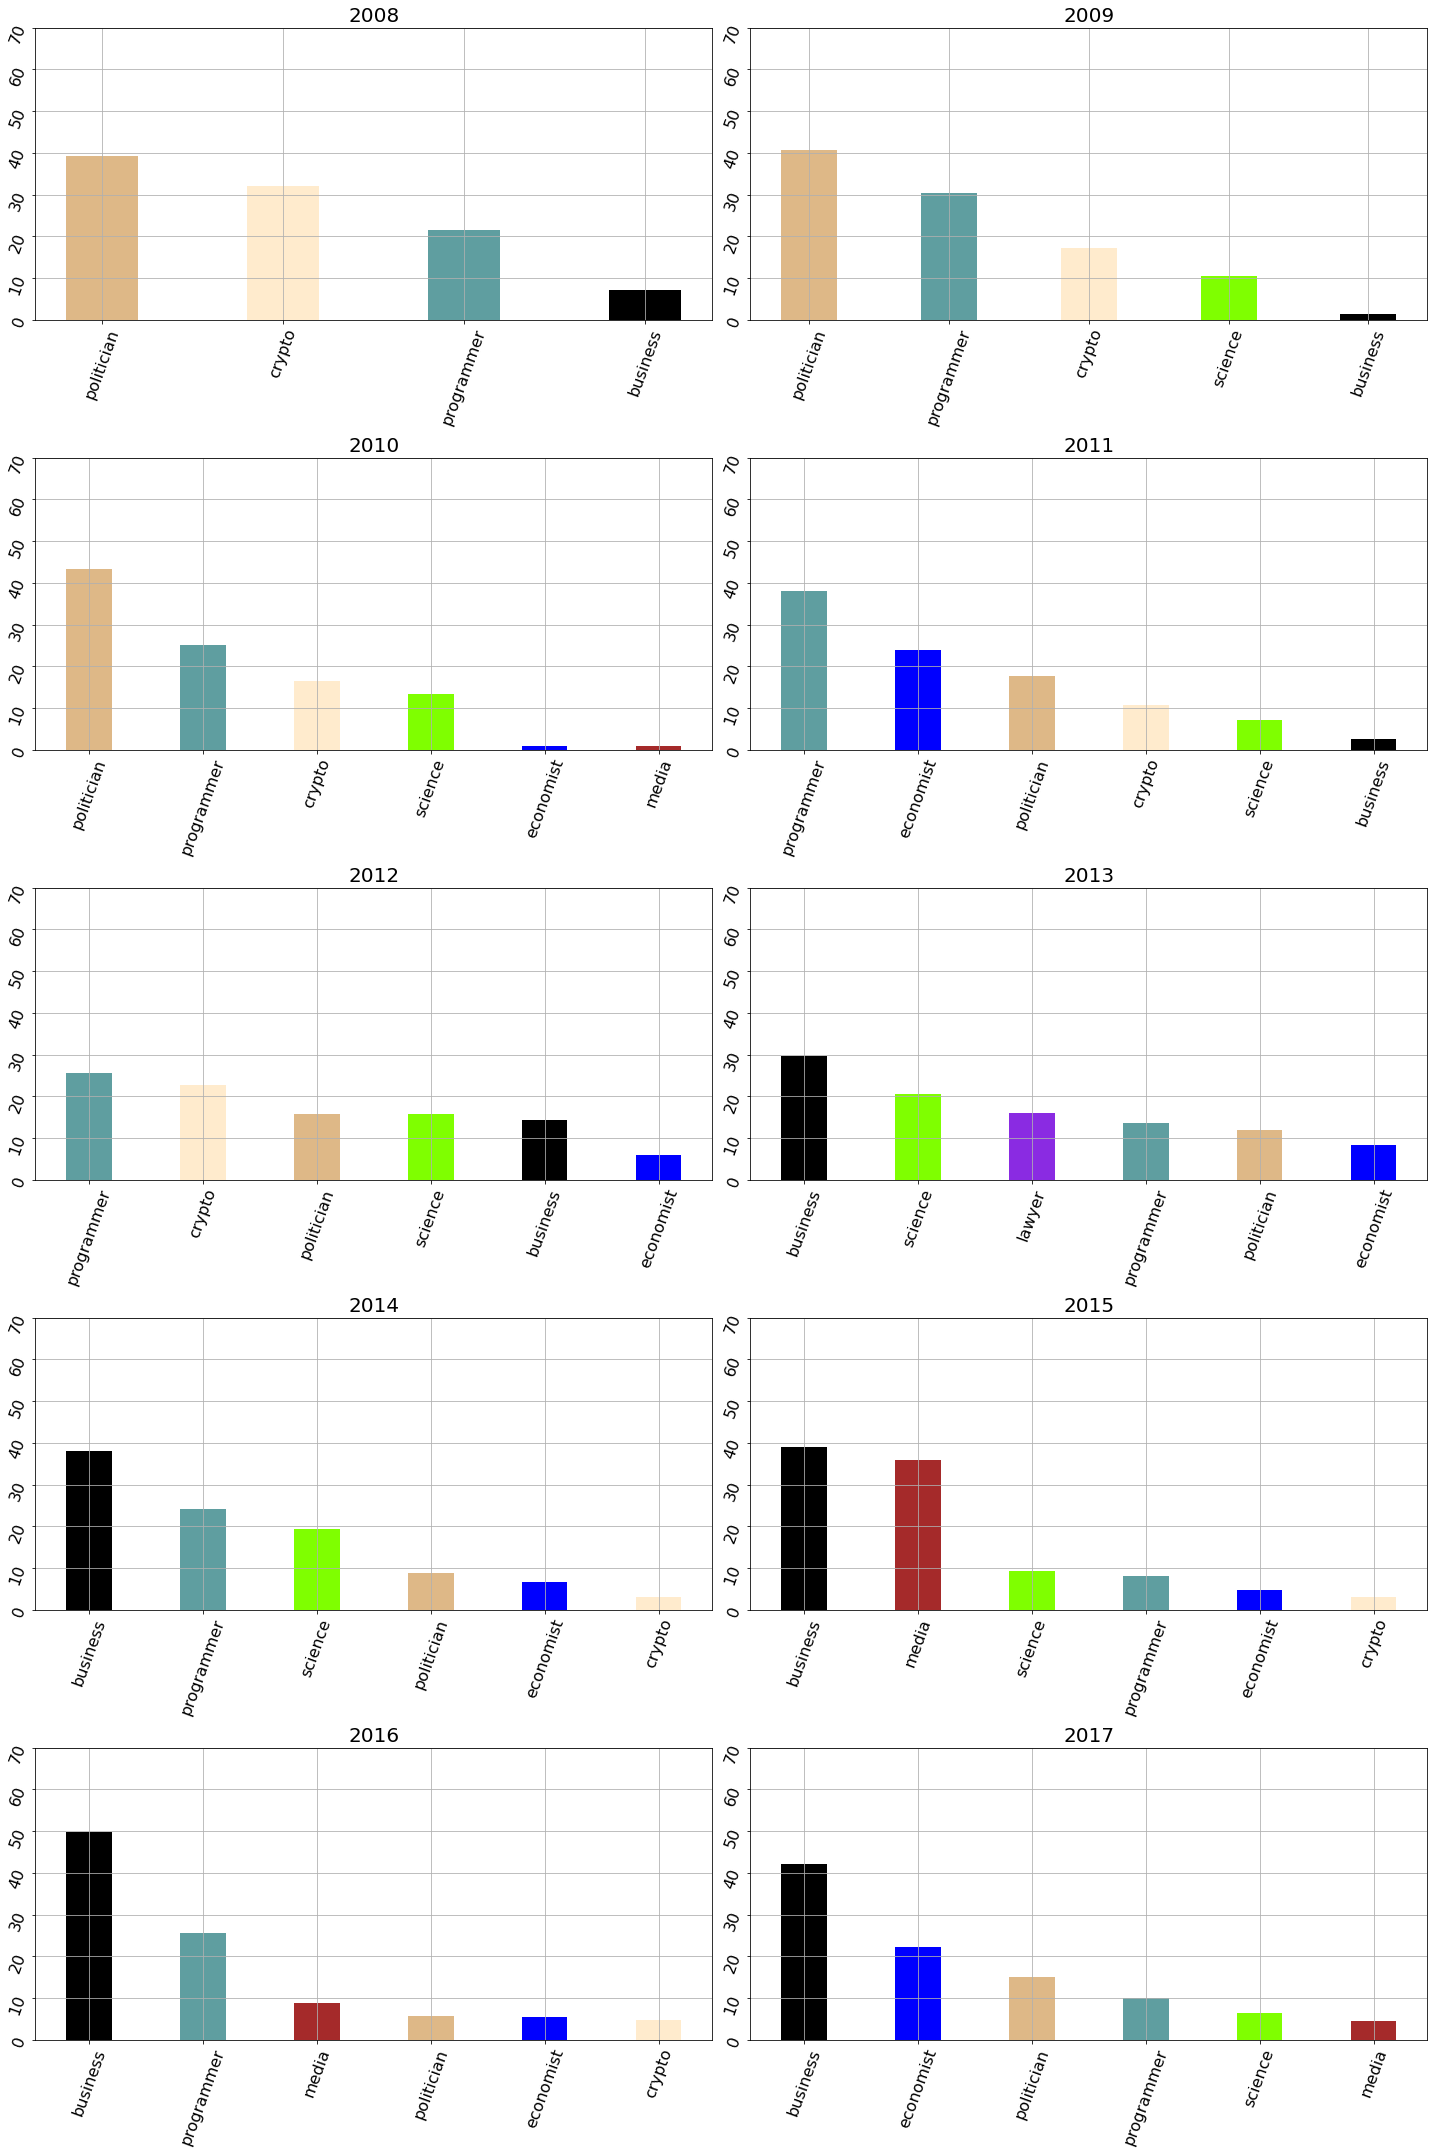

In [18]:
plot_hists(df)

> It seems like the distribution over is a little varied. As we can see, people with sport `occupation` speak up about `bitcoin` and `blockchain` rather more frequent, then other people. It is an interesting observation, since most of the quotes seems to be relevant to `bitcoin`, `blockchain`, and other buzz-words

In [19]:
df[['q', 'd', 's', 'o', 'gender', 'birth', 'occupation']].to_csv("data/preprocessed.csv", index=False)

---

### TODO Set this to percentages

In [20]:
year2total = df_grouped_top.groupby("publish_year").sum().to_dict()["o"]

NameError: name 'df_grouped_top' is not defined

In [ ]:
import plotly.express as px

df_grouped = df.groupby(['publish_year', 'occupation'], as_index=False).sum()
df_grouped_top = df_grouped.sort_values(['publish_year','o'], ascending=False).groupby(['publish_year'], as_index=False).head(6)
df_grouped_top["o"] = df_grouped_top.apply(lambda x: 100 * x["o"] / year2total[x["publish_year"]], axis=1)
fig = px.histogram(df_grouped_top, 
                   x="occupation",
                   y="o", 
                   animation_frame="publish_year",
                   color="occupation",
                   hover_name="publish_year")

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.update_xaxes(fixedrange=False)
fig.update_xaxes(autorange=True)
fig.update_xaxes(categoryorder='total descending')
fig.update_yaxes(range=[0, 100])
fig.show()